<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# NLP Exercise

In today's exercise we have ~15,000 tweets aimed at various US airlines. Their sentiments are pre-labelled, and it's your task to build a classifier that can predict a tweet's sentiment based on its text.

#### Import the data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.read_csv("../assets/data/airline_tweets.csv", encoding="latin-1")
print(df.shape)
df.head()

(14640, 3)


,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...


#### 1: Exploration

- how many airlines are there?
- what is the proportion of sentiment across tweets?

In [2]:
df["airline"].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [3]:
df["airline_sentiment"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [4]:
df["airline_sentiment"].value_counts() / len(df)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

A bit of imbalance in both airlines and sentiment, but we'll see how it performs!

The "baseline" accuracy is 62%, as we could achieve that by just predicting everything as negative, so that's the score to beat.

In [5]:
df.isnull().sum()

airline_sentiment    0
airline              0
text                 0
dtype: int64

#### 2: Data cleaning

- tidy up the tweets as you see fit
- you might want to remove Twitter handles for example

In [6]:
# test the approach on a single tweet
tweet = df["text"].values[0]

words_remove_handle = [w.lower() for w in tweet.split() if not w.startswith("@")]
words_remove_handle

['what', 'said.']

One word has a full stop, which we could remove manually, but the CountVectorizer will also take care of it for us.

Let's verify this by making `words_remove_handle` above into a single string and passing it through the `CountVectorizer`.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
vec.fit([" ".join(words_remove_handle)])
vec.vocabulary_

{'what': 1, 'said': 0}

In [8]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')

def clean_up_tweet(tweet):
    # step 1: remove handles and stitch back into a single string
    words_no_handles = [w.lower() for w in tweet.split() if not w.startswith("@")]
    # step 2: stemming
    return " ".join([stemmer.stem(w) for w in words_no_handles])

In [9]:
df["text_cleaned"] = df["text"].apply(clean_up_tweet)
df.head()

,airline_sentiment,airline,text,text_cleaned
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,what said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,plus you'v ad commerci to the experience... ta...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,i didn't today... must mean i need to take ano...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,"it realli aggress to blast obnoxi ""entertainme..."
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,and it a realli big bad thing about it


#### 3: Train-test split

Do a train-test split so we can test our best algorithm at the end

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["text_cleaned"],
                                                    df["airline_sentiment"],
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=df["airline_sentiment"])

#### 4: Try a simple binary count-based model

- Transform your raw text into binary features
- *Hint: it's a simple parameter change in `CountVectorizer`*
- Choose an appropriate machine learning model for the task
- Use cross-validation to evaluate your model's performance on the training set

In [11]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def evaluate_vectorizer(vec, X, y):
    X_train_text = vec.fit_transform(X)
    rf = RandomForestClassifier()
    accuracy_scores = cross_val_score(rf, X_train_text, y, scoring="accuracy", cv=5)
    print("Accuracy: ", np.mean(accuracy_scores))

evaluate_vectorizer(CountVectorizer(binary=True, stop_words="english"), X_train, y_train)

Accuracy:  0.7324393102134147


#### 5: Try playing around with some of the options in `CountVectorizer`

In [12]:
evaluate_vectorizer(CountVectorizer(binary=False, stop_words="english", min_df=2), X_train, y_train)

Accuracy:  0.7315565929878047


In [13]:
evaluate_vectorizer(CountVectorizer(binary=False,
                                    stop_words="english",
                                    min_df=2,
                                    ngram_range=(1, 2),
                                    max_features=2000),
                    X_train,
                    y_train)

Accuracy:  0.7272654344512194


The binary model seems to actually work slightly better!

#### 6: Try moving to a TF-IDF model. Can you improve on your best score?

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

evaluate_vectorizer(TfidfVectorizer(stop_words="english",
                                    min_df=2),
                    X_train,
                    y_train)

Accuracy:  0.7340932736280488


In [15]:
evaluate_vectorizer(TfidfVectorizer(stop_words="english",
                                    min_df=2,
                                    ngram_range=(1, 2)),
                    X_train,
                    y_train)

Accuracy:  0.7320440167682927


#### 7: Evaluate your best model (the one with the highest cross-validated score) on your test set. What is its final performance?

When you evaluate your model on the test set, remember to **only fit your Vectorizer on the training set** and use the fit Vectorizer to transform the test set. This is just like the rule for using z-score standardisation. We don't want the test set to interfere in our data transformations.

Also make sure to look at more than just a single score - consider printing the confusion matrix for example!

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score

vec = TfidfVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))
X_train_text = vec.fit_transform(X_train)
X_test_text = vec.transform(X_test)

rf = RandomForestClassifier()
rf.fit(X_train_text, y_train)
y_pred = rf.predict(X_test_text)

print(accuracy_score(y_test, y_pred))


0.735655737704918


Text(0.5,1,'Confusion Matrix')

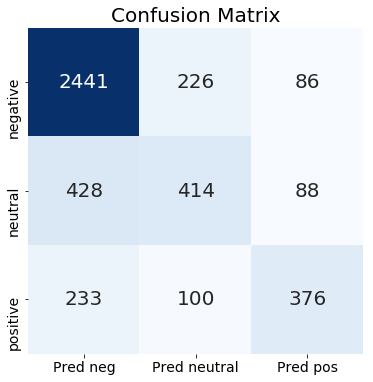

In [17]:
conmat = np.array(confusion_matrix(y_test, rf.predict(X_test_text)))
confusion = pd.DataFrame(conmat, index=['negative', 'neutral', 'positive'],\
                     columns=['Pred neg', 'Pred neutral', 'Pred pos'])

plt.figure(figsize = (6,6))
heat = sns.heatmap(confusion, annot=True, annot_kws={"size": 20},cmap='Blues',fmt='g', cbar=False)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title("Confusion Matrix", fontsize=20)


Just so we know what the rows correspond to...

In [18]:
y_test.value_counts()

negative    2753
neutral      930
positive     709
Name: airline_sentiment, dtype: int64

As expected, we're better at identifying negative reviews, surprisingly OK at positive ones, and terrible at neutral ones.

Perhaps it makes more sense to only look for positive vs. negative - that would probably get a better result.